In [69]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
from kerastuner import HyperModel

NUMERIC_FEATURES = [
    'p1_height',
    'p2_height',
    'p1_age',
    'p2_age',
    'p1_rating',
    'p2_rating',
    'p1_dev',
    'p2_dev',
    'p1_surface_rating',
    'p2_surface_rating',
    'p1_surface_dev',
    'p2_surface_dev',
    'p1_w',
    'p2_w',
    'p1_l',
    'p2_l',
    'p1_surface_w',
    'p2_surface_w',
    'p1_surface_l',
    'p2_surface_l',
    'p1_inactive_days',
    'p2_inactive_days',
    'p1_recent_rating',
    'p2_recent_rating'
]
CATEGORICAL_FEATURES = [
    'is_hard',
    'is_clay',
    'is_grass',
    'is_bo5',
    'p1_lefty',
    'p2_lefty',
    'p1_home',
    'p2_home'
    
]

dataframe = pd.read_csv('../data/matches.csv')[7389:76425]
validation = pd.read_csv('../data/matches.csv')[76425:]


def build_model(preprocessing_head, inputs, hidden_layer, learning_rate, dropout):
  body = tf.keras.Sequential([
    keras.layers.InputLayer(input_shape=(32,)),
    keras.layers.Dense(hidden_layer, activation='relu'),
    keras.layers.Dropout(dropout),
    keras.layers.Dense(1, activation='sigmoid')
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=tf.keras.optimizers.Adam(learning_rate),
                metrics='acc')
  return model


In [70]:
class MyHyperModel(HyperModel):
    def __init__(self, preprocessing_head, inputs):
        self.preprocessing_head = preprocessing_head
        self.inputs = inputs
    def build(self, hp):
        body = tf.keras.Sequential([
            keras.layers.InputLayer(input_shape=(32,)),
            keras.layers.Dense(hp.Int('hidden_size', 200, 600), activation='relu'),
            keras.layers.Dropout(hp.Float('dropout', 0.05, 0.5)),
            keras.layers.Dense(1, activation='sigmoid')
        ])

        preprocessed_inputs = self.preprocessing_head(self.inputs)
        result = body(preprocessed_inputs)
        model = tf.keras.Model(self.inputs, result)

        model.compile(
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                      optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 0.003, 0.03)),
                      metrics=['acc']
                      )
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Int("batch_size", 2000, 6000),
            **kwargs,
        )

In [71]:
def get_model(dataframe, hidden_layer, learning_rate, dropout):
    labels = dataframe.pop('p1_win')
    dataframe.pop('match_hash')
    dataframe.pop('tourney_name')
    dataframe.pop('tourney_date')
    dataframe.pop('p1_name')
    dataframe.pop('p2_name')

    dataframe_features = dataframe.copy()

    inputs = {}

    # match column names with input objects
    for name, column in dataframe_features.items():
        dtype = tf.float32
        inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

    numeric_inputs = {name:input for name,input in inputs.items()
                    if name in NUMERIC_FEATURES}

    # normalize the numeric inputs and gather them in an array
    x = keras.layers.Concatenate()(list(numeric_inputs.values()))
    norm = keras.layers.Normalization()
    norm.adapt(np.array(dataframe[numeric_inputs.keys()]))
    all_numeric_inputs = norm(x)

    preprocessed_inputs = [all_numeric_inputs]

    for name, input in inputs.items():
        if name in NUMERIC_FEATURES:
            continue
        preprocessed_inputs.append(input)

    preprocessed_inputs_cat = keras.layers.Concatenate()(preprocessed_inputs)
    preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

    features_dict = {name: np.array(value) for name, value in dataframe_features.items()}
    f_dict = {name:values for name, values in features_dict.items()}
    preprocessing(f_dict)

    # data_model = MyHyperModel(preprocessing, inputs)
    data_model = build_model(preprocessing, inputs, hidden_layer, learning_rate, dropout)

    return data_model, features_dict, labels

In [72]:
for hidden_layer in range(1000, 1601, 100):
    for learning_rate in range(3, 20, 2):
        learning_rate = learning_rate / 10000
        for int_dropout in range(45, 46, 5):
            dropout = int_dropout / 100
            # dataframe = pd.read_csv('../data/matches.csv')[7389:76425]
            # validation = pd.read_csv('../data/matches.csv')[76425:]
            dataframe = pd.read_csv('../data/matches.csv')[7389:51327]
            validation = pd.read_csv('../data/matches.csv')[51327:68157]
            # validation = pd.read_csv('../data/matches.csv')[51327:]
            data_model, features_dict, labels = get_model(dataframe, hidden_layer, learning_rate, dropout)
            _, val_features_dict, val_labels = get_model(validation, hidden_layer, learning_rate, dropout)

            for trial in range(5):
                data_model.fit(x=features_dict, y=labels, epochs=20000, batch_size=5696, 
                            callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=10)],
                            validation_data=(val_features_dict, val_labels),
                    )
                data_model.save(f'hidden{hidden_layer}lr{learning_rate}dropout{dropout}trial{trial}')

                # data_model.save(f'test{trial}')



# data_model, features_dict, labels = get_model(dataframe, 0,0,0)
# _, val_features_dict, val_labels = get_model(validation, 0,0,0)
# tuner = kt.BayesianOptimization(data_model, objective='loss', directory='training_weights', max_trials=80)
# tuner.search(x=features_dict, y=labels, epochs=20000, 
#              validation_data=(val_features_dict, val_labels),
#              callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=15)]
#             )

Epoch 1/20000
8/8 [==============================] - 3s 207ms/step - loss: 0.6502 - acc: 0.6259 - val_loss: 0.6513 - val_acc: 0.6214
Epoch 2/20000
8/8 [==============================] - 1s 151ms/step - loss: 0.6176 - acc: 0.6597 - val_loss: 0.6387 - val_acc: 0.6367
Epoch 3/20000
8/8 [==============================] - 1s 145ms/step - loss: 0.6108 - acc: 0.6636 - val_loss: 0.6371 - val_acc: 0.6414
Epoch 4/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.6086 - acc: 0.6653 - val_loss: 0.6366 - val_acc: 0.6422
Epoch 5/20000
8/8 [==============================] - 1s 154ms/step - loss: 0.6068 - acc: 0.6679 - val_loss: 0.6361 - val_acc: 0.6395
Epoch 6/20000
8/8 [==============================] - 1s 143ms/step - loss: 0.6058 - acc: 0.6683 - val_loss: 0.6332 - val_acc: 0.6409
Epoch 7/20000
8/8 [==============================] - 1s 141ms/step - loss: 0.6046 - acc: 0.6677 - val_loss: 0.6323 - val_acc: 0.6416
Epoch 8/20000
8/8 [==============================] - 1s 141ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.15trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.15trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 231ms/step - loss: 0.5565 - acc: 0.7107 - val_loss: 0.6434 - val_acc: 0.6403
Epoch 2/20000
8/8 [==============================] - 1s 176ms/step - loss: 0.5556 - acc: 0.7123 - val_loss: 0.6422 - val_acc: 0.6398
Epoch 3/20000
8/8 [==============================] - 2s 193ms/step - loss: 0.5544 - acc: 0.7123 - val_loss: 0.6437 - val_acc: 0.6399
Epoch 4/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.5537 - acc: 0.7126 - val_loss: 0.6420 - val_acc: 0.6403
Epoch 5/20000
8/8 [==============================] - 2s 202ms/step - loss: 0.5542 - acc: 0.7122 - val_loss: 0.6433 - val_acc: 0.6369
Epoch 6/20000
8/8 [==============================] - 2s 215ms/step - loss: 0.5543 - acc: 0.7133 - val_loss: 0.6435 - val_acc: 0.6387
Epoch 7/20000
8/8 [==============================] - 2s 261ms/step - loss: 0.5537 - acc: 0.7143 - val_loss: 0.6415 - val_acc: 0.6395
Epoch 8/20000
8/8 [==============================] - 2s 269ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.15trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.15trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 194ms/step - loss: 0.5531 - acc: 0.7127 - val_loss: 0.6462 - val_acc: 0.6376
Epoch 2/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5541 - acc: 0.7125 - val_loss: 0.6412 - val_acc: 0.6396
Epoch 3/20000
8/8 [==============================] - 1s 177ms/step - loss: 0.5528 - acc: 0.7122 - val_loss: 0.6436 - val_acc: 0.6405
Epoch 4/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5541 - acc: 0.7120 - val_loss: 0.6446 - val_acc: 0.6395
Epoch 5/20000
8/8 [==============================] - 1s 158ms/step - loss: 0.5540 - acc: 0.7122 - val_loss: 0.6462 - val_acc: 0.6386
Epoch 6/20000
8/8 [==============================] - 1s 154ms/step - loss: 0.5529 - acc: 0.7134 - val_loss: 0.6427 - val_acc: 0.6381
Epoch 7/20000
8/8 [==============================] - 1s 153ms/step - loss: 0.5527 - acc: 0.7140 - val_loss: 0.6452 - val_acc: 0.6373
Epoch 8/20000
8/8 [==============================] - 1s 164ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.15trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.15trial2\assets


Epoch 1/20000
8/8 [==============================] - 2s 204ms/step - loss: 0.5512 - acc: 0.7133 - val_loss: 0.6446 - val_acc: 0.6403
Epoch 2/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.5522 - acc: 0.7136 - val_loss: 0.6442 - val_acc: 0.6408
Epoch 3/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5511 - acc: 0.7138 - val_loss: 0.6441 - val_acc: 0.6392
Epoch 4/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5519 - acc: 0.7140 - val_loss: 0.6451 - val_acc: 0.6391
Epoch 5/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.5514 - acc: 0.7138 - val_loss: 0.6444 - val_acc: 0.6384
Epoch 6/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.5515 - acc: 0.7130 - val_loss: 0.6444 - val_acc: 0.6368
Epoch 7/20000
8/8 [==============================] - 1s 184ms/step - loss: 0.5506 - acc: 0.7162 - val_loss: 0.6454 - val_acc: 0.6392
Epoch 8/20000
8/8 [==============================] - 1s 170ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.15trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.15trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 200ms/step - loss: 0.5463 - acc: 0.7197 - val_loss: 0.6493 - val_acc: 0.6379
Epoch 2/20000
8/8 [==============================] - 1s 155ms/step - loss: 0.5441 - acc: 0.7191 - val_loss: 0.6515 - val_acc: 0.6359
Epoch 3/20000
8/8 [==============================] - 1s 158ms/step - loss: 0.5446 - acc: 0.7197 - val_loss: 0.6475 - val_acc: 0.6383
Epoch 4/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.5455 - acc: 0.7186 - val_loss: 0.6491 - val_acc: 0.6389
Epoch 5/20000
8/8 [==============================] - 1s 155ms/step - loss: 0.5451 - acc: 0.7211 - val_loss: 0.6499 - val_acc: 0.6372
Epoch 6/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5456 - acc: 0.7189 - val_loss: 0.6498 - val_acc: 0.6354
Epoch 7/20000
8/8 [==============================] - 1s 153ms/step - loss: 0.5460 - acc: 0.7170 - val_loss: 0.6503 - val_acc: 0.6354
Epoch 8/20000
8/8 [==============================] - 1s 150ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.15trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.15trial4\assets


Epoch 1/20000
8/8 [==============================] - 2s 200ms/step - loss: 0.6573 - acc: 0.6107 - val_loss: 0.6561 - val_acc: 0.6141
Epoch 2/20000
8/8 [==============================] - 1s 176ms/step - loss: 0.6200 - acc: 0.6603 - val_loss: 0.6408 - val_acc: 0.6350
Epoch 3/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.6115 - acc: 0.6625 - val_loss: 0.6361 - val_acc: 0.6414
Epoch 4/20000
8/8 [==============================] - 1s 176ms/step - loss: 0.6092 - acc: 0.6649 - val_loss: 0.6369 - val_acc: 0.6412
Epoch 5/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.6072 - acc: 0.6680 - val_loss: 0.6361 - val_acc: 0.6401
Epoch 6/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.6060 - acc: 0.6686 - val_loss: 0.6340 - val_acc: 0.6420
Epoch 7/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.6052 - acc: 0.6676 - val_loss: 0.6321 - val_acc: 0.6434
Epoch 8/20000
8/8 [==============================] - 1s 177ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.2trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.2trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 214ms/step - loss: 0.5604 - acc: 0.7073 - val_loss: 0.6412 - val_acc: 0.6401
Epoch 2/20000
8/8 [==============================] - 2s 213ms/step - loss: 0.5591 - acc: 0.7090 - val_loss: 0.6415 - val_acc: 0.6415
Epoch 3/20000
8/8 [==============================] - 1s 190ms/step - loss: 0.5608 - acc: 0.7074 - val_loss: 0.6428 - val_acc: 0.6402
Epoch 4/20000
8/8 [==============================] - 2s 191ms/step - loss: 0.5587 - acc: 0.7086 - val_loss: 0.6427 - val_acc: 0.6391
Epoch 5/20000
8/8 [==============================] - 2s 194ms/step - loss: 0.5593 - acc: 0.7102 - val_loss: 0.6412 - val_acc: 0.6406
Epoch 6/20000
8/8 [==============================] - 1s 189ms/step - loss: 0.5605 - acc: 0.7079 - val_loss: 0.6418 - val_acc: 0.6406
Epoch 7/20000
8/8 [==============================] - 1s 185ms/step - loss: 0.5599 - acc: 0.7077 - val_loss: 0.6434 - val_acc: 0.6371
Epoch 8/20000
8/8 [==============================] - 1s 182ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.2trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.2trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 201ms/step - loss: 0.5572 - acc: 0.7116 - val_loss: 0.6411 - val_acc: 0.6409
Epoch 2/20000
8/8 [==============================] - 1s 146ms/step - loss: 0.5576 - acc: 0.7087 - val_loss: 0.6421 - val_acc: 0.6425
Epoch 3/20000
8/8 [==============================] - 1s 145ms/step - loss: 0.5587 - acc: 0.7085 - val_loss: 0.6423 - val_acc: 0.6408
Epoch 4/20000
8/8 [==============================] - 1s 146ms/step - loss: 0.5567 - acc: 0.7108 - val_loss: 0.6435 - val_acc: 0.6380
Epoch 5/20000
8/8 [==============================] - 1s 146ms/step - loss: 0.5576 - acc: 0.7098 - val_loss: 0.6428 - val_acc: 0.6419
Epoch 6/20000
8/8 [==============================] - 1s 157ms/step - loss: 0.5574 - acc: 0.7113 - val_loss: 0.6417 - val_acc: 0.6413
Epoch 7/20000
8/8 [==============================] - 1s 155ms/step - loss: 0.5567 - acc: 0.7105 - val_loss: 0.6450 - val_acc: 0.6387
Epoch 8/20000
8/8 [==============================] - 1s 149ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.2trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.2trial2\assets


Epoch 1/20000
8/8 [==============================] - 2s 198ms/step - loss: 0.5567 - acc: 0.7095 - val_loss: 0.6421 - val_acc: 0.6394
Epoch 2/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.5558 - acc: 0.7125 - val_loss: 0.6448 - val_acc: 0.6410
Epoch 3/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.5543 - acc: 0.7136 - val_loss: 0.6426 - val_acc: 0.6399
Epoch 4/20000
8/8 [==============================] - 1s 191ms/step - loss: 0.5562 - acc: 0.7113 - val_loss: 0.6436 - val_acc: 0.6416
Epoch 5/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.5557 - acc: 0.7125 - val_loss: 0.6420 - val_acc: 0.6400
Epoch 6/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.5559 - acc: 0.7103 - val_loss: 0.6433 - val_acc: 0.6417
Epoch 7/20000
8/8 [==============================] - 1s 172ms/step - loss: 0.5568 - acc: 0.7103 - val_loss: 0.6430 - val_acc: 0.6409
Epoch 8/20000
8/8 [==============================] - 1s 191ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.2trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.2trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 252ms/step - loss: 0.5554 - acc: 0.7125 - val_loss: 0.6443 - val_acc: 0.6395
Epoch 2/20000
8/8 [==============================] - 1s 190ms/step - loss: 0.5556 - acc: 0.7099 - val_loss: 0.6421 - val_acc: 0.6417
Epoch 3/20000
8/8 [==============================] - 2s 194ms/step - loss: 0.5553 - acc: 0.7127 - val_loss: 0.6450 - val_acc: 0.6399
Epoch 4/20000
8/8 [==============================] - 1s 184ms/step - loss: 0.5547 - acc: 0.7130 - val_loss: 0.6438 - val_acc: 0.6393
Epoch 5/20000
8/8 [==============================] - 1s 185ms/step - loss: 0.5548 - acc: 0.7115 - val_loss: 0.6430 - val_acc: 0.6397
Epoch 6/20000
8/8 [==============================] - 2s 196ms/step - loss: 0.5552 - acc: 0.7117 - val_loss: 0.6436 - val_acc: 0.6411
Epoch 7/20000
8/8 [==============================] - 2s 197ms/step - loss: 0.5553 - acc: 0.7108 - val_loss: 0.6444 - val_acc: 0.6381
Epoch 8/20000
8/8 [==============================] - 1s 173ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.2trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.2trial4\assets


Epoch 1/20000
8/8 [==============================] - 2s 201ms/step - loss: 0.6670 - acc: 0.5871 - val_loss: 0.6524 - val_acc: 0.6128
Epoch 2/20000
8/8 [==============================] - 1s 154ms/step - loss: 0.6227 - acc: 0.6534 - val_loss: 0.6491 - val_acc: 0.6275
Epoch 3/20000
8/8 [==============================] - 1s 182ms/step - loss: 0.6135 - acc: 0.6629 - val_loss: 0.6368 - val_acc: 0.6380
Epoch 4/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.6094 - acc: 0.6650 - val_loss: 0.6358 - val_acc: 0.6422
Epoch 5/20000
8/8 [==============================] - 1s 168ms/step - loss: 0.6080 - acc: 0.6648 - val_loss: 0.6359 - val_acc: 0.6410
Epoch 6/20000
8/8 [==============================] - 1s 169ms/step - loss: 0.6068 - acc: 0.6672 - val_loss: 0.6357 - val_acc: 0.6405
Epoch 7/20000
8/8 [==============================] - 1s 168ms/step - loss: 0.6058 - acc: 0.6675 - val_loss: 0.6342 - val_acc: 0.6398
Epoch 8/20000
8/8 [==============================] - 1s 167ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.25trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.25trial0\assets


Epoch 1/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.5755 - acc: 0.6957 - val_loss: 0.6334 - val_acc: 0.6415
Epoch 2/20000
8/8 [==============================] - 1s 155ms/step - loss: 0.5756 - acc: 0.6953 - val_loss: 0.6328 - val_acc: 0.6420
Epoch 3/20000
8/8 [==============================] - 1s 176ms/step - loss: 0.5759 - acc: 0.6952 - val_loss: 0.6337 - val_acc: 0.6413
Epoch 4/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.5750 - acc: 0.6954 - val_loss: 0.6327 - val_acc: 0.6436
Epoch 5/20000
8/8 [==============================] - 1s 172ms/step - loss: 0.5764 - acc: 0.6939 - val_loss: 0.6334 - val_acc: 0.6426
Epoch 6/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.5750 - acc: 0.6961 - val_loss: 0.6326 - val_acc: 0.6412
Epoch 7/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.5747 - acc: 0.6965 - val_loss: 0.6331 - val_acc: 0.6424
Epoch 8/20000
8/8 [==============================] - 1s 164ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.25trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.25trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 199ms/step - loss: 0.5668 - acc: 0.7023 - val_loss: 0.6409 - val_acc: 0.6384
Epoch 2/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.5663 - acc: 0.7018 - val_loss: 0.6383 - val_acc: 0.6412
Epoch 3/20000
8/8 [==============================] - 1s 180ms/step - loss: 0.5653 - acc: 0.7024 - val_loss: 0.6379 - val_acc: 0.6398
Epoch 4/20000
8/8 [==============================] - 1s 182ms/step - loss: 0.5662 - acc: 0.7032 - val_loss: 0.6395 - val_acc: 0.6408
Epoch 5/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.5673 - acc: 0.7020 - val_loss: 0.6374 - val_acc: 0.6424
Epoch 6/20000
8/8 [==============================] - 1s 175ms/step - loss: 0.5668 - acc: 0.7020 - val_loss: 0.6369 - val_acc: 0.6418
Epoch 7/20000
8/8 [==============================] - 1s 176ms/step - loss: 0.5668 - acc: 0.7023 - val_loss: 0.6385 - val_acc: 0.6416
Epoch 8/20000
8/8 [==============================] - 1s 177ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.25trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.25trial2\assets


Epoch 1/20000
8/8 [==============================] - 1s 180ms/step - loss: 0.5638 - acc: 0.7054 - val_loss: 0.6376 - val_acc: 0.6425
Epoch 2/20000
8/8 [==============================] - 1s 149ms/step - loss: 0.5642 - acc: 0.7039 - val_loss: 0.6410 - val_acc: 0.6428
Epoch 3/20000
8/8 [==============================] - 1s 154ms/step - loss: 0.5652 - acc: 0.7044 - val_loss: 0.6384 - val_acc: 0.6417
Epoch 4/20000
8/8 [==============================] - 1s 189ms/step - loss: 0.5641 - acc: 0.7046 - val_loss: 0.6394 - val_acc: 0.6425
Epoch 5/20000
8/8 [==============================] - 1s 160ms/step - loss: 0.5641 - acc: 0.7046 - val_loss: 0.6396 - val_acc: 0.6414
Epoch 6/20000
8/8 [==============================] - 1s 154ms/step - loss: 0.5637 - acc: 0.7039 - val_loss: 0.6386 - val_acc: 0.6420
Epoch 7/20000
8/8 [==============================] - 1s 160ms/step - loss: 0.5643 - acc: 0.7053 - val_loss: 0.6395 - val_acc: 0.6436
Epoch 8/20000
8/8 [==============================] - 1s 166ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.25trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.25trial3\assets


Epoch 1/20000
8/8 [==============================] - 1s 188ms/step - loss: 0.5626 - acc: 0.7074 - val_loss: 0.6393 - val_acc: 0.6421
Epoch 2/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.5636 - acc: 0.7054 - val_loss: 0.6394 - val_acc: 0.6428
Epoch 3/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.5620 - acc: 0.7073 - val_loss: 0.6399 - val_acc: 0.6387
Epoch 4/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.5616 - acc: 0.7072 - val_loss: 0.6427 - val_acc: 0.6399
Epoch 5/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.5618 - acc: 0.7039 - val_loss: 0.6397 - val_acc: 0.6437
Epoch 6/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5633 - acc: 0.7046 - val_loss: 0.6393 - val_acc: 0.6392
Epoch 7/20000
8/8 [==============================] - 1s 158ms/step - loss: 0.5629 - acc: 0.7037 - val_loss: 0.6412 - val_acc: 0.6424
Epoch 8/20000
8/8 [==============================] - 1s 154ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.25trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.25trial4\assets


Epoch 1/20000
8/8 [==============================] - 2s 188ms/step - loss: 0.6587 - acc: 0.6033 - val_loss: 0.6546 - val_acc: 0.6148
Epoch 2/20000
8/8 [==============================] - 1s 152ms/step - loss: 0.6208 - acc: 0.6549 - val_loss: 0.6442 - val_acc: 0.6331
Epoch 3/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.6124 - acc: 0.6617 - val_loss: 0.6374 - val_acc: 0.6399
Epoch 4/20000
8/8 [==============================] - 1s 157ms/step - loss: 0.6103 - acc: 0.6642 - val_loss: 0.6371 - val_acc: 0.6415
Epoch 5/20000
8/8 [==============================] - 1s 152ms/step - loss: 0.6084 - acc: 0.6656 - val_loss: 0.6369 - val_acc: 0.6392
Epoch 6/20000
8/8 [==============================] - 1s 154ms/step - loss: 0.6072 - acc: 0.6664 - val_loss: 0.6348 - val_acc: 0.6391
Epoch 7/20000
8/8 [==============================] - 1s 155ms/step - loss: 0.6062 - acc: 0.6678 - val_loss: 0.6328 - val_acc: 0.6408
Epoch 8/20000
8/8 [==============================] - 1s 180ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.3trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.3trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 212ms/step - loss: 0.5660 - acc: 0.7044 - val_loss: 0.6363 - val_acc: 0.6421
Epoch 2/20000
8/8 [==============================] - 1s 177ms/step - loss: 0.5671 - acc: 0.7020 - val_loss: 0.6381 - val_acc: 0.6439
Epoch 3/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.5662 - acc: 0.7027 - val_loss: 0.6380 - val_acc: 0.6435
Epoch 4/20000
8/8 [==============================] - 1s 168ms/step - loss: 0.5667 - acc: 0.7038 - val_loss: 0.6367 - val_acc: 0.6433
Epoch 5/20000
8/8 [==============================] - 1s 169ms/step - loss: 0.5673 - acc: 0.7048 - val_loss: 0.6382 - val_acc: 0.6428
Epoch 6/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.5663 - acc: 0.7040 - val_loss: 0.6378 - val_acc: 0.6420
Epoch 7/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.5676 - acc: 0.7007 - val_loss: 0.6394 - val_acc: 0.6401
Epoch 8/20000
8/8 [==============================] - 1s 184ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.3trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.3trial1\assets


Epoch 1/20000
8/8 [==============================] - 1s 190ms/step - loss: 0.5656 - acc: 0.7049 - val_loss: 0.6386 - val_acc: 0.6435
Epoch 2/20000
8/8 [==============================] - 1s 154ms/step - loss: 0.5647 - acc: 0.7032 - val_loss: 0.6377 - val_acc: 0.6433
Epoch 3/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.5642 - acc: 0.7035 - val_loss: 0.6383 - val_acc: 0.6408
Epoch 4/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.5644 - acc: 0.7045 - val_loss: 0.6407 - val_acc: 0.6403
Epoch 5/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.5644 - acc: 0.7034 - val_loss: 0.6387 - val_acc: 0.6389
Epoch 6/20000
8/8 [==============================] - 1s 169ms/step - loss: 0.5646 - acc: 0.7028 - val_loss: 0.6394 - val_acc: 0.6430
Epoch 7/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.5663 - acc: 0.7036 - val_loss: 0.6380 - val_acc: 0.6424
Epoch 8/20000
8/8 [==============================] - 1s 161ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.3trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.3trial2\assets


Epoch 1/20000
8/8 [==============================] - 2s 194ms/step - loss: 0.5629 - acc: 0.7065 - val_loss: 0.6400 - val_acc: 0.6419
Epoch 2/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.5622 - acc: 0.7053 - val_loss: 0.6410 - val_acc: 0.6402
Epoch 3/20000
8/8 [==============================] - 1s 179ms/step - loss: 0.5626 - acc: 0.7069 - val_loss: 0.6392 - val_acc: 0.6419
Epoch 4/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.5625 - acc: 0.7054 - val_loss: 0.6400 - val_acc: 0.6424
Epoch 5/20000
8/8 [==============================] - 1s 168ms/step - loss: 0.5625 - acc: 0.7064 - val_loss: 0.6404 - val_acc: 0.6418
Epoch 6/20000
8/8 [==============================] - 1s 175ms/step - loss: 0.5626 - acc: 0.7054 - val_loss: 0.6401 - val_acc: 0.6429
Epoch 7/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5603 - acc: 0.7092 - val_loss: 0.6399 - val_acc: 0.6424
Epoch 8/20000
8/8 [==============================] - 1s 157ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.3trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.3trial3\assets


Epoch 1/20000
8/8 [==============================] - 1s 187ms/step - loss: 0.5596 - acc: 0.7076 - val_loss: 0.6404 - val_acc: 0.6422
Epoch 2/20000
8/8 [==============================] - 1s 153ms/step - loss: 0.5617 - acc: 0.7059 - val_loss: 0.6414 - val_acc: 0.6415
Epoch 3/20000
8/8 [==============================] - 1s 155ms/step - loss: 0.5624 - acc: 0.7059 - val_loss: 0.6393 - val_acc: 0.6424
Epoch 4/20000
8/8 [==============================] - 1s 156ms/step - loss: 0.5612 - acc: 0.7053 - val_loss: 0.6411 - val_acc: 0.6418
Epoch 5/20000
8/8 [==============================] - 1s 177ms/step - loss: 0.5606 - acc: 0.7062 - val_loss: 0.6413 - val_acc: 0.6389
Epoch 6/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5619 - acc: 0.7080 - val_loss: 0.6411 - val_acc: 0.6427
Epoch 7/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.5606 - acc: 0.7066 - val_loss: 0.6404 - val_acc: 0.6400
Epoch 8/20000
8/8 [==============================] - 1s 162ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.3trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.3trial4\assets


Epoch 1/20000
8/8 [==============================] - 3s 211ms/step - loss: 0.6601 - acc: 0.6013 - val_loss: 0.6529 - val_acc: 0.6201
Epoch 2/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.6212 - acc: 0.6567 - val_loss: 0.6455 - val_acc: 0.6340
Epoch 3/20000
8/8 [==============================] - 2s 197ms/step - loss: 0.6136 - acc: 0.6628 - val_loss: 0.6364 - val_acc: 0.6409
Epoch 4/20000
8/8 [==============================] - 1s 182ms/step - loss: 0.6107 - acc: 0.6647 - val_loss: 0.6358 - val_acc: 0.6430
Epoch 5/20000
8/8 [==============================] - 1s 186ms/step - loss: 0.6092 - acc: 0.6656 - val_loss: 0.6353 - val_acc: 0.6403
Epoch 6/20000
8/8 [==============================] - 1s 179ms/step - loss: 0.6079 - acc: 0.6658 - val_loss: 0.6348 - val_acc: 0.6397
Epoch 7/20000
8/8 [==============================] - 1s 186ms/step - loss: 0.6064 - acc: 0.6679 - val_loss: 0.6332 - val_acc: 0.6402
Epoch 8/20000
8/8 [==============================] - 1s 179ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.35trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.35trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 192ms/step - loss: 0.5746 - acc: 0.6946 - val_loss: 0.6342 - val_acc: 0.6421
Epoch 2/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.5735 - acc: 0.6963 - val_loss: 0.6351 - val_acc: 0.6426
Epoch 3/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.5741 - acc: 0.6963 - val_loss: 0.6341 - val_acc: 0.6430
Epoch 4/20000
8/8 [==============================] - 1s 188ms/step - loss: 0.5740 - acc: 0.6976 - val_loss: 0.6380 - val_acc: 0.6383
Epoch 5/20000
8/8 [==============================] - 1s 186ms/step - loss: 0.5740 - acc: 0.6966 - val_loss: 0.6347 - val_acc: 0.6425
Epoch 6/20000
8/8 [==============================] - 1s 176ms/step - loss: 0.5743 - acc: 0.6970 - val_loss: 0.6346 - val_acc: 0.6427
Epoch 7/20000
8/8 [==============================] - 1s 180ms/step - loss: 0.5737 - acc: 0.6957 - val_loss: 0.6345 - val_acc: 0.6426
Epoch 8/20000
8/8 [==============================] - 2s 208ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.35trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.35trial1\assets


Epoch 1/20000
8/8 [==============================] - 1s 185ms/step - loss: 0.5723 - acc: 0.6962 - val_loss: 0.6353 - val_acc: 0.6428
Epoch 2/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.5728 - acc: 0.6959 - val_loss: 0.6375 - val_acc: 0.6415
Epoch 3/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.5731 - acc: 0.6958 - val_loss: 0.6354 - val_acc: 0.6428
Epoch 4/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5715 - acc: 0.6968 - val_loss: 0.6355 - val_acc: 0.6428
Epoch 5/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5730 - acc: 0.6968 - val_loss: 0.6354 - val_acc: 0.6424
Epoch 6/20000
8/8 [==============================] - 1s 160ms/step - loss: 0.5720 - acc: 0.6991 - val_loss: 0.6359 - val_acc: 0.6431
Epoch 7/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5714 - acc: 0.6973 - val_loss: 0.6352 - val_acc: 0.6427
Epoch 8/20000
8/8 [==============================] - 1s 182ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.35trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.35trial2\assets


Epoch 1/20000
8/8 [==============================] - 1s 187ms/step - loss: 0.5679 - acc: 0.7012 - val_loss: 0.6382 - val_acc: 0.6420
Epoch 2/20000
8/8 [==============================] - 1s 155ms/step - loss: 0.5685 - acc: 0.7005 - val_loss: 0.6367 - val_acc: 0.6421
Epoch 3/20000
8/8 [==============================] - 1s 156ms/step - loss: 0.5675 - acc: 0.7017 - val_loss: 0.6359 - val_acc: 0.6433
Epoch 4/20000
8/8 [==============================] - 1s 156ms/step - loss: 0.5682 - acc: 0.7019 - val_loss: 0.6385 - val_acc: 0.6435
Epoch 5/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.5665 - acc: 0.7034 - val_loss: 0.6362 - val_acc: 0.6431
Epoch 6/20000
8/8 [==============================] - 2s 192ms/step - loss: 0.5687 - acc: 0.7015 - val_loss: 0.6386 - val_acc: 0.6431
Epoch 7/20000
8/8 [==============================] - 2s 199ms/step - loss: 0.5677 - acc: 0.6995 - val_loss: 0.6366 - val_acc: 0.6431
Epoch 8/20000
8/8 [==============================] - 1s 170ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.35trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.35trial3\assets


Epoch 1/20000
8/8 [==============================] - 1s 188ms/step - loss: 0.5679 - acc: 0.6996 - val_loss: 0.6380 - val_acc: 0.6433
Epoch 2/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5673 - acc: 0.7011 - val_loss: 0.6376 - val_acc: 0.6397
Epoch 3/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.5667 - acc: 0.7006 - val_loss: 0.6377 - val_acc: 0.6433
Epoch 4/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.5661 - acc: 0.7020 - val_loss: 0.6365 - val_acc: 0.6422
Epoch 5/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.5663 - acc: 0.7030 - val_loss: 0.6390 - val_acc: 0.6410
Epoch 6/20000
8/8 [==============================] - 2s 183ms/step - loss: 0.5653 - acc: 0.7044 - val_loss: 0.6367 - val_acc: 0.6419
Epoch 7/20000
8/8 [==============================] - 1s 177ms/step - loss: 0.5657 - acc: 0.7037 - val_loss: 0.6380 - val_acc: 0.6411
Epoch 8/20000
8/8 [==============================] - 1s 176ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.35trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.35trial4\assets


Epoch 1/20000
8/8 [==============================] - 2s 210ms/step - loss: 0.6590 - acc: 0.6007 - val_loss: 0.6560 - val_acc: 0.6144
Epoch 2/20000
8/8 [==============================] - 1s 193ms/step - loss: 0.6232 - acc: 0.6528 - val_loss: 0.6421 - val_acc: 0.6343
Epoch 3/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.6140 - acc: 0.6613 - val_loss: 0.6355 - val_acc: 0.6424
Epoch 4/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.6104 - acc: 0.6640 - val_loss: 0.6366 - val_acc: 0.6408
Epoch 5/20000
8/8 [==============================] - 1s 169ms/step - loss: 0.6096 - acc: 0.6659 - val_loss: 0.6377 - val_acc: 0.6387
Epoch 6/20000
8/8 [==============================] - 1s 164ms/step - loss: 0.6089 - acc: 0.6653 - val_loss: 0.6362 - val_acc: 0.6395
Epoch 7/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.6068 - acc: 0.6668 - val_loss: 0.6328 - val_acc: 0.6411
Epoch 8/20000
8/8 [==============================] - 1s 160ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.4trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.4trial0\assets


Epoch 1/20000
8/8 [==============================] - 1s 192ms/step - loss: 0.5857 - acc: 0.6858 - val_loss: 0.6294 - val_acc: 0.6433
Epoch 2/20000
8/8 [==============================] - 1s 153ms/step - loss: 0.5852 - acc: 0.6862 - val_loss: 0.6297 - val_acc: 0.6447
Epoch 3/20000
8/8 [==============================] - 1s 154ms/step - loss: 0.5849 - acc: 0.6880 - val_loss: 0.6299 - val_acc: 0.6448
Epoch 4/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.5851 - acc: 0.6870 - val_loss: 0.6298 - val_acc: 0.6449
Epoch 5/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.5853 - acc: 0.6872 - val_loss: 0.6314 - val_acc: 0.6427
Epoch 6/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5847 - acc: 0.6871 - val_loss: 0.6295 - val_acc: 0.6452
Epoch 7/20000
8/8 [==============================] - 1s 155ms/step - loss: 0.5853 - acc: 0.6859 - val_loss: 0.6297 - val_acc: 0.6439
Epoch 8/20000
8/8 [==============================] - 1s 155ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.4trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.4trial1\assets


Epoch 1/20000
8/8 [==============================] - 1s 193ms/step - loss: 0.5834 - acc: 0.6884 - val_loss: 0.6308 - val_acc: 0.6441
Epoch 2/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.5824 - acc: 0.6896 - val_loss: 0.6304 - val_acc: 0.6423
Epoch 3/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.5820 - acc: 0.6892 - val_loss: 0.6316 - val_acc: 0.6459
Epoch 4/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5824 - acc: 0.6892 - val_loss: 0.6312 - val_acc: 0.6437
Epoch 5/20000
8/8 [==============================] - 1s 176ms/step - loss: 0.5826 - acc: 0.6878 - val_loss: 0.6317 - val_acc: 0.6423
Epoch 6/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.5824 - acc: 0.6891 - val_loss: 0.6311 - val_acc: 0.6433
Epoch 7/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.5823 - acc: 0.6881 - val_loss: 0.6308 - val_acc: 0.6444
Epoch 8/20000
8/8 [==============================] - 1s 169ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.4trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.4trial2\assets


Epoch 1/20000
8/8 [==============================] - 2s 192ms/step - loss: 0.5710 - acc: 0.7001 - val_loss: 0.6354 - val_acc: 0.6439
Epoch 2/20000
8/8 [==============================] - 1s 188ms/step - loss: 0.5706 - acc: 0.6975 - val_loss: 0.6351 - val_acc: 0.6453
Epoch 3/20000
8/8 [==============================] - 1s 169ms/step - loss: 0.5714 - acc: 0.6977 - val_loss: 0.6347 - val_acc: 0.6449
Epoch 4/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.5700 - acc: 0.7000 - val_loss: 0.6353 - val_acc: 0.6454
Epoch 5/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.5704 - acc: 0.6995 - val_loss: 0.6359 - val_acc: 0.6433
Epoch 6/20000
8/8 [==============================] - 1s 169ms/step - loss: 0.5709 - acc: 0.6991 - val_loss: 0.6347 - val_acc: 0.6447
Epoch 7/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.5702 - acc: 0.6980 - val_loss: 0.6347 - val_acc: 0.6447
Epoch 8/20000
8/8 [==============================] - 1s 182ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.4trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.4trial3\assets


Epoch 1/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.5695 - acc: 0.6983 - val_loss: 0.6363 - val_acc: 0.6434
Epoch 2/20000
8/8 [==============================] - 1s 160ms/step - loss: 0.5695 - acc: 0.7003 - val_loss: 0.6350 - val_acc: 0.6462
Epoch 3/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.5679 - acc: 0.7014 - val_loss: 0.6353 - val_acc: 0.6461
Epoch 4/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5687 - acc: 0.7006 - val_loss: 0.6361 - val_acc: 0.6439
Epoch 5/20000
8/8 [==============================] - 1s 186ms/step - loss: 0.5686 - acc: 0.7028 - val_loss: 0.6353 - val_acc: 0.6451
Epoch 6/20000
8/8 [==============================] - 1s 172ms/step - loss: 0.5704 - acc: 0.6988 - val_loss: 0.6388 - val_acc: 0.6390
Epoch 7/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.5694 - acc: 0.7013 - val_loss: 0.6349 - val_acc: 0.6447
Epoch 8/20000
8/8 [==============================] - 1s 166ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.4trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.4trial4\assets


Epoch 1/20000
8/8 [==============================] - 2s 198ms/step - loss: 0.6553 - acc: 0.6093 - val_loss: 0.6494 - val_acc: 0.6189
Epoch 2/20000
8/8 [==============================] - 1s 147ms/step - loss: 0.6215 - acc: 0.6537 - val_loss: 0.6437 - val_acc: 0.6331
Epoch 3/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.6147 - acc: 0.6617 - val_loss: 0.6382 - val_acc: 0.6377
Epoch 4/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.6118 - acc: 0.6625 - val_loss: 0.6372 - val_acc: 0.6400
Epoch 5/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.6101 - acc: 0.6633 - val_loss: 0.6370 - val_acc: 0.6398
Epoch 6/20000
8/8 [==============================] - 1s 158ms/step - loss: 0.6088 - acc: 0.6658 - val_loss: 0.6362 - val_acc: 0.6378
Epoch 7/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.6077 - acc: 0.6666 - val_loss: 0.6334 - val_acc: 0.6403
Epoch 8/20000
8/8 [==============================] - 1s 159ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 200ms/step - loss: 0.5793 - acc: 0.6923 - val_loss: 0.6323 - val_acc: 0.6435
Epoch 2/20000
8/8 [==============================] - 1s 150ms/step - loss: 0.5785 - acc: 0.6948 - val_loss: 0.6325 - val_acc: 0.6440
Epoch 3/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5793 - acc: 0.6923 - val_loss: 0.6331 - val_acc: 0.6432
Epoch 4/20000
8/8 [==============================] - 1s 175ms/step - loss: 0.5798 - acc: 0.6913 - val_loss: 0.6320 - val_acc: 0.6439
Epoch 5/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5803 - acc: 0.6932 - val_loss: 0.6319 - val_acc: 0.6439
Epoch 6/20000
8/8 [==============================] - 1s 157ms/step - loss: 0.5781 - acc: 0.6930 - val_loss: 0.6326 - val_acc: 0.6425
Epoch 7/20000
8/8 [==============================] - 1s 157ms/step - loss: 0.5790 - acc: 0.6902 - val_loss: 0.6325 - val_acc: 0.6440
Epoch 8/20000
8/8 [==============================] - 1s 159ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 191ms/step - loss: 0.5763 - acc: 0.6957 - val_loss: 0.6335 - val_acc: 0.6436
Epoch 2/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.5769 - acc: 0.6941 - val_loss: 0.6331 - val_acc: 0.6437
Epoch 3/20000
8/8 [==============================] - 1s 164ms/step - loss: 0.5773 - acc: 0.6950 - val_loss: 0.6334 - val_acc: 0.6437
Epoch 4/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.5767 - acc: 0.6956 - val_loss: 0.6334 - val_acc: 0.6443
Epoch 5/20000
8/8 [==============================] - 1s 168ms/step - loss: 0.5755 - acc: 0.6959 - val_loss: 0.6331 - val_acc: 0.6440
Epoch 6/20000
8/8 [==============================] - 1s 179ms/step - loss: 0.5756 - acc: 0.6959 - val_loss: 0.6342 - val_acc: 0.6433
Epoch 7/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.5769 - acc: 0.6942 - val_loss: 0.6332 - val_acc: 0.6439
Epoch 8/20000
8/8 [==============================] - 1s 165ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 1s 187ms/step - loss: 0.5726 - acc: 0.6985 - val_loss: 0.6341 - val_acc: 0.6429
Epoch 2/20000
8/8 [==============================] - 1s 156ms/step - loss: 0.5738 - acc: 0.6981 - val_loss: 0.6355 - val_acc: 0.6430
Epoch 3/20000
8/8 [==============================] - 1s 158ms/step - loss: 0.5752 - acc: 0.6959 - val_loss: 0.6344 - val_acc: 0.6430
Epoch 4/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.5737 - acc: 0.6970 - val_loss: 0.6343 - val_acc: 0.6439
Epoch 5/20000
8/8 [==============================] - 1s 157ms/step - loss: 0.5741 - acc: 0.6972 - val_loss: 0.6353 - val_acc: 0.6431
Epoch 6/20000
8/8 [==============================] - 1s 184ms/step - loss: 0.5738 - acc: 0.6971 - val_loss: 0.6347 - val_acc: 0.6435
Epoch 7/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.5745 - acc: 0.6968 - val_loss: 0.6340 - val_acc: 0.6439
Epoch 8/20000
8/8 [==============================] - 1s 160ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 1s 184ms/step - loss: 0.5734 - acc: 0.6963 - val_loss: 0.6357 - val_acc: 0.6411
Epoch 2/20000
8/8 [==============================] - 1s 158ms/step - loss: 0.5741 - acc: 0.6961 - val_loss: 0.6339 - val_acc: 0.6440
Epoch 3/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.5733 - acc: 0.6989 - val_loss: 0.6339 - val_acc: 0.6446
Epoch 4/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.5716 - acc: 0.6979 - val_loss: 0.6343 - val_acc: 0.6437
Epoch 5/20000
8/8 [==============================] - 1s 187ms/step - loss: 0.5725 - acc: 0.6986 - val_loss: 0.6350 - val_acc: 0.6433
Epoch 6/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.5739 - acc: 0.6959 - val_loss: 0.6342 - val_acc: 0.6436
Epoch 7/20000
8/8 [==============================] - 1s 168ms/step - loss: 0.5729 - acc: 0.6985 - val_loss: 0.6353 - val_acc: 0.6437
Epoch 8/20000
8/8 [==============================] - 1s 167ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial4\assets


Epoch 1/20000
8/8 [==============================] - 2s 220ms/step - loss: 0.6593 - acc: 0.6024 - val_loss: 0.6563 - val_acc: 0.6153
Epoch 2/20000
8/8 [==============================] - 1s 158ms/step - loss: 0.6223 - acc: 0.6529 - val_loss: 0.6441 - val_acc: 0.6342
Epoch 3/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.6141 - acc: 0.6624 - val_loss: 0.6365 - val_acc: 0.6409
Epoch 4/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.6122 - acc: 0.6621 - val_loss: 0.6365 - val_acc: 0.6417
Epoch 5/20000
8/8 [==============================] - 2s 194ms/step - loss: 0.6103 - acc: 0.6642 - val_loss: 0.6364 - val_acc: 0.6394
Epoch 6/20000
8/8 [==============================] - 1s 177ms/step - loss: 0.6083 - acc: 0.6640 - val_loss: 0.6355 - val_acc: 0.6407
Epoch 7/20000
8/8 [==============================] - 1s 176ms/step - loss: 0.6074 - acc: 0.6641 - val_loss: 0.6330 - val_acc: 0.6416
Epoch 8/20000
8/8 [==============================] - 1s 177ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.5trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.5trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 196ms/step - loss: 0.5815 - acc: 0.6901 - val_loss: 0.6318 - val_acc: 0.6441
Epoch 2/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.5806 - acc: 0.6896 - val_loss: 0.6317 - val_acc: 0.6438
Epoch 3/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5817 - acc: 0.6902 - val_loss: 0.6332 - val_acc: 0.6429
Epoch 4/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5808 - acc: 0.6912 - val_loss: 0.6319 - val_acc: 0.6457
Epoch 5/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.5809 - acc: 0.6904 - val_loss: 0.6324 - val_acc: 0.6443
Epoch 6/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5811 - acc: 0.6901 - val_loss: 0.6315 - val_acc: 0.6441
Epoch 7/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5814 - acc: 0.6912 - val_loss: 0.6341 - val_acc: 0.6412
Epoch 8/20000
8/8 [==============================] - 1s 185ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.5trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.5trial1\assets


Epoch 1/20000
8/8 [==============================] - 1s 188ms/step - loss: 0.5717 - acc: 0.6999 - val_loss: 0.6361 - val_acc: 0.6436
Epoch 2/20000
8/8 [==============================] - 1s 157ms/step - loss: 0.5715 - acc: 0.6987 - val_loss: 0.6359 - val_acc: 0.6436
Epoch 3/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5710 - acc: 0.6995 - val_loss: 0.6352 - val_acc: 0.6458
Epoch 4/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5716 - acc: 0.6993 - val_loss: 0.6360 - val_acc: 0.6450
Epoch 5/20000
8/8 [==============================] - 1s 187ms/step - loss: 0.5720 - acc: 0.6985 - val_loss: 0.6359 - val_acc: 0.6449
Epoch 6/20000
8/8 [==============================] - 1s 164ms/step - loss: 0.5717 - acc: 0.6990 - val_loss: 0.6362 - val_acc: 0.6427
Epoch 7/20000
8/8 [==============================] - 1s 164ms/step - loss: 0.5706 - acc: 0.7009 - val_loss: 0.6362 - val_acc: 0.6458
Epoch 8/20000
8/8 [==============================] - 1s 165ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.5trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.5trial2\assets


Epoch 1/20000
8/8 [==============================] - 1s 169ms/step - loss: 0.5693 - acc: 0.7007 - val_loss: 0.6350 - val_acc: 0.6444
Epoch 2/20000
8/8 [==============================] - 1s 154ms/step - loss: 0.5713 - acc: 0.6996 - val_loss: 0.6371 - val_acc: 0.6443
Epoch 3/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.5712 - acc: 0.6984 - val_loss: 0.6356 - val_acc: 0.6452
Epoch 4/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.5716 - acc: 0.7000 - val_loss: 0.6370 - val_acc: 0.6455
Epoch 5/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.5707 - acc: 0.6992 - val_loss: 0.6351 - val_acc: 0.6449
Epoch 6/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5697 - acc: 0.7004 - val_loss: 0.6371 - val_acc: 0.6435
Epoch 7/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5711 - acc: 0.7006 - val_loss: 0.6362 - val_acc: 0.6455
Epoch 8/20000
8/8 [==============================] - 1s 162ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.5trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.5trial3\assets


Epoch 1/20000
8/8 [==============================] - 1s 188ms/step - loss: 0.5699 - acc: 0.7006 - val_loss: 0.6359 - val_acc: 0.6452
Epoch 2/20000
8/8 [==============================] - 1s 160ms/step - loss: 0.5701 - acc: 0.6999 - val_loss: 0.6358 - val_acc: 0.6443
Epoch 3/20000
8/8 [==============================] - 1s 157ms/step - loss: 0.5695 - acc: 0.7007 - val_loss: 0.6365 - val_acc: 0.6447
Epoch 4/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.5708 - acc: 0.7008 - val_loss: 0.6373 - val_acc: 0.6425
Epoch 5/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5708 - acc: 0.6996 - val_loss: 0.6365 - val_acc: 0.6448
Epoch 6/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5690 - acc: 0.7005 - val_loss: 0.6356 - val_acc: 0.6447
Epoch 7/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.5690 - acc: 0.6991 - val_loss: 0.6372 - val_acc: 0.6425
Epoch 8/20000
8/8 [==============================] - 1s 162ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.5trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.5trial4\assets


Epoch 1/20000
8/8 [==============================] - 2s 201ms/step - loss: 0.6619 - acc: 0.5975 - val_loss: 0.6512 - val_acc: 0.6182
Epoch 2/20000
8/8 [==============================] - 1s 156ms/step - loss: 0.6252 - acc: 0.6500 - val_loss: 0.6454 - val_acc: 0.6320
Epoch 3/20000
8/8 [==============================] - 1s 179ms/step - loss: 0.6163 - acc: 0.6608 - val_loss: 0.6362 - val_acc: 0.6393
Epoch 4/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.6133 - acc: 0.6624 - val_loss: 0.6357 - val_acc: 0.6400
Epoch 5/20000
8/8 [==============================] - 1s 172ms/step - loss: 0.6105 - acc: 0.6645 - val_loss: 0.6356 - val_acc: 0.6415
Epoch 6/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.6100 - acc: 0.6642 - val_loss: 0.6355 - val_acc: 0.6402
Epoch 7/20000
8/8 [==============================] - 1s 169ms/step - loss: 0.6091 - acc: 0.6660 - val_loss: 0.6332 - val_acc: 0.6410
Epoch 8/20000
8/8 [==============================] - 1s 186ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.55trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.55trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 217ms/step - loss: 0.5849 - acc: 0.6873 - val_loss: 0.6300 - val_acc: 0.6445
Epoch 2/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.5847 - acc: 0.6874 - val_loss: 0.6310 - val_acc: 0.6440
Epoch 3/20000
8/8 [==============================] - 1s 185ms/step - loss: 0.5854 - acc: 0.6879 - val_loss: 0.6299 - val_acc: 0.6459
Epoch 4/20000
8/8 [==============================] - 1s 177ms/step - loss: 0.5851 - acc: 0.6875 - val_loss: 0.6309 - val_acc: 0.6443
Epoch 5/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.5858 - acc: 0.6879 - val_loss: 0.6305 - val_acc: 0.6454
Epoch 6/20000
8/8 [==============================] - 2s 195ms/step - loss: 0.5850 - acc: 0.6871 - val_loss: 0.6307 - val_acc: 0.6451
Epoch 7/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.5847 - acc: 0.6863 - val_loss: 0.6305 - val_acc: 0.6452
Epoch 8/20000
8/8 [==============================] - 1s 163ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.55trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.55trial1\assets


Epoch 1/20000
8/8 [==============================] - 1s 187ms/step - loss: 0.5847 - acc: 0.6880 - val_loss: 0.6309 - val_acc: 0.6444
Epoch 2/20000
8/8 [==============================] - 1s 155ms/step - loss: 0.5838 - acc: 0.6874 - val_loss: 0.6305 - val_acc: 0.6464
Epoch 3/20000
8/8 [==============================] - 1s 156ms/step - loss: 0.5847 - acc: 0.6876 - val_loss: 0.6305 - val_acc: 0.6452
Epoch 4/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.5838 - acc: 0.6875 - val_loss: 0.6304 - val_acc: 0.6452
Epoch 5/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.5849 - acc: 0.6875 - val_loss: 0.6305 - val_acc: 0.6443
Epoch 6/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.5838 - acc: 0.6866 - val_loss: 0.6310 - val_acc: 0.6438
Epoch 7/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.5848 - acc: 0.6880 - val_loss: 0.6308 - val_acc: 0.6450
Epoch 8/20000
8/8 [==============================] - 1s 163ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.55trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.55trial2\assets


Epoch 1/20000
8/8 [==============================] - 2s 222ms/step - loss: 0.5799 - acc: 0.6895 - val_loss: 0.6324 - val_acc: 0.6443
Epoch 2/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.5805 - acc: 0.6912 - val_loss: 0.6315 - val_acc: 0.6444
Epoch 3/20000
8/8 [==============================] - 2s 211ms/step - loss: 0.5804 - acc: 0.6930 - val_loss: 0.6321 - val_acc: 0.6460
Epoch 4/20000
8/8 [==============================] - 2s 261ms/step - loss: 0.5803 - acc: 0.6913 - val_loss: 0.6317 - val_acc: 0.6449
Epoch 5/20000
8/8 [==============================] - 2s 215ms/step - loss: 0.5795 - acc: 0.6920 - val_loss: 0.6326 - val_acc: 0.6439
Epoch 6/20000
8/8 [==============================] - 2s 192ms/step - loss: 0.5800 - acc: 0.6905 - val_loss: 0.6319 - val_acc: 0.6446
Epoch 7/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.5789 - acc: 0.6914 - val_loss: 0.6320 - val_acc: 0.6451
Epoch 8/20000
8/8 [==============================] - 1s 160ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.55trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.55trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 195ms/step - loss: 0.5785 - acc: 0.6918 - val_loss: 0.6333 - val_acc: 0.6427
Epoch 2/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.5776 - acc: 0.6946 - val_loss: 0.6331 - val_acc: 0.6436
Epoch 3/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.5772 - acc: 0.6920 - val_loss: 0.6328 - val_acc: 0.6427
Epoch 4/20000
8/8 [==============================] - 1s 180ms/step - loss: 0.5776 - acc: 0.6944 - val_loss: 0.6332 - val_acc: 0.6444
Epoch 5/20000
8/8 [==============================] - 1s 184ms/step - loss: 0.5762 - acc: 0.6945 - val_loss: 0.6334 - val_acc: 0.6437
Epoch 6/20000
8/8 [==============================] - 2s 197ms/step - loss: 0.5766 - acc: 0.6959 - val_loss: 0.6332 - val_acc: 0.6424
Epoch 7/20000
8/8 [==============================] - 1s 184ms/step - loss: 0.5770 - acc: 0.6932 - val_loss: 0.6340 - val_acc: 0.6437
Epoch 8/20000
8/8 [==============================] - 1s 185ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.55trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.55trial4\assets


Epoch 1/20000
8/8 [==============================] - 2s 195ms/step - loss: 0.6640 - acc: 0.5926 - val_loss: 0.6570 - val_acc: 0.6113
Epoch 2/20000
8/8 [==============================] - 1s 149ms/step - loss: 0.6250 - acc: 0.6494 - val_loss: 0.6452 - val_acc: 0.6326
Epoch 3/20000
8/8 [==============================] - 1s 158ms/step - loss: 0.6184 - acc: 0.6587 - val_loss: 0.6359 - val_acc: 0.6408
Epoch 4/20000
8/8 [==============================] - 1s 158ms/step - loss: 0.6140 - acc: 0.6614 - val_loss: 0.6366 - val_acc: 0.6405
Epoch 5/20000
8/8 [==============================] - 1s 180ms/step - loss: 0.6127 - acc: 0.6630 - val_loss: 0.6370 - val_acc: 0.6401
Epoch 6/20000
8/8 [==============================] - 1s 164ms/step - loss: 0.6104 - acc: 0.6640 - val_loss: 0.6367 - val_acc: 0.6390
Epoch 7/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.6104 - acc: 0.6649 - val_loss: 0.6342 - val_acc: 0.6401
Epoch 8/20000
8/8 [==============================] - 1s 164ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.6trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.6trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 220ms/step - loss: 0.5849 - acc: 0.6879 - val_loss: 0.6308 - val_acc: 0.6433
Epoch 2/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.5845 - acc: 0.6879 - val_loss: 0.6320 - val_acc: 0.6426
Epoch 3/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.5838 - acc: 0.6880 - val_loss: 0.6304 - val_acc: 0.6445
Epoch 4/20000
8/8 [==============================] - 1s 180ms/step - loss: 0.5848 - acc: 0.6870 - val_loss: 0.6327 - val_acc: 0.6436
Epoch 5/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.5842 - acc: 0.6880 - val_loss: 0.6308 - val_acc: 0.6442
Epoch 6/20000
8/8 [==============================] - 2s 199ms/step - loss: 0.5842 - acc: 0.6885 - val_loss: 0.6321 - val_acc: 0.6434
Epoch 7/20000
8/8 [==============================] - 1s 184ms/step - loss: 0.5839 - acc: 0.6903 - val_loss: 0.6313 - val_acc: 0.6429
Epoch 8/20000
8/8 [==============================] - 1s 171ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.6trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.6trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 205ms/step - loss: 0.5818 - acc: 0.6900 - val_loss: 0.6328 - val_acc: 0.6431
Epoch 2/20000
8/8 [==============================] - 1s 185ms/step - loss: 0.5818 - acc: 0.6890 - val_loss: 0.6316 - val_acc: 0.6439
Epoch 3/20000
8/8 [==============================] - 1s 184ms/step - loss: 0.5817 - acc: 0.6898 - val_loss: 0.6321 - val_acc: 0.6444
Epoch 4/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.5820 - acc: 0.6884 - val_loss: 0.6324 - val_acc: 0.6428
Epoch 5/20000
8/8 [==============================] - 1s 175ms/step - loss: 0.5817 - acc: 0.6899 - val_loss: 0.6319 - val_acc: 0.6439
Epoch 6/20000
8/8 [==============================] - 2s 190ms/step - loss: 0.5814 - acc: 0.6906 - val_loss: 0.6330 - val_acc: 0.6426
Epoch 7/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.5813 - acc: 0.6910 - val_loss: 0.6316 - val_acc: 0.6437
Epoch 8/20000
8/8 [==============================] - 1s 169ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.6trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.6trial2\assets


Epoch 1/20000
8/8 [==============================] - 1s 191ms/step - loss: 0.5812 - acc: 0.6913 - val_loss: 0.6322 - val_acc: 0.6440
Epoch 2/20000
8/8 [==============================] - 1s 155ms/step - loss: 0.5810 - acc: 0.6921 - val_loss: 0.6328 - val_acc: 0.6428
Epoch 3/20000
8/8 [==============================] - 2s 201ms/step - loss: 0.5790 - acc: 0.6924 - val_loss: 0.6324 - val_acc: 0.6441
Epoch 4/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5802 - acc: 0.6935 - val_loss: 0.6321 - val_acc: 0.6448
Epoch 5/20000
8/8 [==============================] - 1s 160ms/step - loss: 0.5805 - acc: 0.6914 - val_loss: 0.6324 - val_acc: 0.6441
Epoch 6/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5798 - acc: 0.6914 - val_loss: 0.6325 - val_acc: 0.6443
Epoch 7/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.5797 - acc: 0.6919 - val_loss: 0.6335 - val_acc: 0.6426
Epoch 8/20000
8/8 [==============================] - 1s 164ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.6trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.6trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 201ms/step - loss: 0.5801 - acc: 0.6909 - val_loss: 0.6323 - val_acc: 0.6435
Epoch 2/20000
8/8 [==============================] - 1s 190ms/step - loss: 0.5808 - acc: 0.6917 - val_loss: 0.6336 - val_acc: 0.6437
Epoch 3/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.5798 - acc: 0.6920 - val_loss: 0.6339 - val_acc: 0.6426
Epoch 4/20000
8/8 [==============================] - 1s 179ms/step - loss: 0.5801 - acc: 0.6917 - val_loss: 0.6329 - val_acc: 0.6436
Epoch 5/20000
8/8 [==============================] - 1s 179ms/step - loss: 0.5799 - acc: 0.6903 - val_loss: 0.6328 - val_acc: 0.6441
Epoch 6/20000
8/8 [==============================] - 2s 206ms/step - loss: 0.5798 - acc: 0.6922 - val_loss: 0.6321 - val_acc: 0.6442
Epoch 7/20000
8/8 [==============================] - 1s 187ms/step - loss: 0.5798 - acc: 0.6924 - val_loss: 0.6332 - val_acc: 0.6449
Epoch 8/20000
8/8 [==============================] - 1s 170ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.6trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.6trial4\assets


Epoch 1/20000
8/8 [==============================] - 3s 231ms/step - loss: 0.6694 - acc: 0.5843 - val_loss: 0.6543 - val_acc: 0.6143
Epoch 2/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.6270 - acc: 0.6482 - val_loss: 0.6476 - val_acc: 0.6307
Epoch 3/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.6192 - acc: 0.6573 - val_loss: 0.6373 - val_acc: 0.6406
Epoch 4/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.6148 - acc: 0.6607 - val_loss: 0.6364 - val_acc: 0.6409
Epoch 5/20000
8/8 [==============================] - 2s 263ms/step - loss: 0.6149 - acc: 0.6615 - val_loss: 0.6358 - val_acc: 0.6411
Epoch 6/20000
8/8 [==============================] - 2s 249ms/step - loss: 0.6124 - acc: 0.6634 - val_loss: 0.6357 - val_acc: 0.6397
Epoch 7/20000
8/8 [==============================] - 2s 218ms/step - loss: 0.6110 - acc: 0.6646 - val_loss: 0.6335 - val_acc: 0.6412
Epoch 8/20000
8/8 [==============================] - 1s 180ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.65trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.65trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 235ms/step - loss: 0.5887 - acc: 0.6835 - val_loss: 0.6297 - val_acc: 0.6455
Epoch 2/20000
8/8 [==============================] - 2s 214ms/step - loss: 0.5875 - acc: 0.6845 - val_loss: 0.6300 - val_acc: 0.6469
Epoch 3/20000
8/8 [==============================] - 2s 197ms/step - loss: 0.5894 - acc: 0.6832 - val_loss: 0.6303 - val_acc: 0.6458
Epoch 4/20000
8/8 [==============================] - 2s 195ms/step - loss: 0.5882 - acc: 0.6847 - val_loss: 0.6296 - val_acc: 0.6461
Epoch 5/20000
8/8 [==============================] - 2s 216ms/step - loss: 0.5880 - acc: 0.6839 - val_loss: 0.6298 - val_acc: 0.6450
Epoch 6/20000
8/8 [==============================] - 2s 201ms/step - loss: 0.5878 - acc: 0.6835 - val_loss: 0.6296 - val_acc: 0.6469
Epoch 7/20000
8/8 [==============================] - 2s 202ms/step - loss: 0.5880 - acc: 0.6848 - val_loss: 0.6298 - val_acc: 0.6451
Epoch 8/20000
8/8 [==============================] - 2s 204ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.65trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.65trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 225ms/step - loss: 0.5829 - acc: 0.6883 - val_loss: 0.6312 - val_acc: 0.6460
Epoch 2/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.5823 - acc: 0.6897 - val_loss: 0.6317 - val_acc: 0.6443
Epoch 3/20000
8/8 [==============================] - 2s 216ms/step - loss: 0.5829 - acc: 0.6897 - val_loss: 0.6319 - val_acc: 0.6462
Epoch 4/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.5833 - acc: 0.6889 - val_loss: 0.6309 - val_acc: 0.6451
Epoch 5/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.5826 - acc: 0.6898 - val_loss: 0.6315 - val_acc: 0.6446
Epoch 6/20000
8/8 [==============================] - 1s 184ms/step - loss: 0.5831 - acc: 0.6874 - val_loss: 0.6311 - val_acc: 0.6449
Epoch 7/20000
8/8 [==============================] - 2s 222ms/step - loss: 0.5817 - acc: 0.6915 - val_loss: 0.6321 - val_acc: 0.6455
Epoch 8/20000
8/8 [==============================] - 2s 222ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.65trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.65trial2\assets


Epoch 1/20000
8/8 [==============================] - 2s 248ms/step - loss: 0.5806 - acc: 0.6925 - val_loss: 0.6325 - val_acc: 0.6443
Epoch 2/20000
8/8 [==============================] - 2s 198ms/step - loss: 0.5825 - acc: 0.6897 - val_loss: 0.6319 - val_acc: 0.6452
Epoch 3/20000
8/8 [==============================] - 2s 230ms/step - loss: 0.5815 - acc: 0.6912 - val_loss: 0.6320 - val_acc: 0.6453
Epoch 4/20000
8/8 [==============================] - 2s 193ms/step - loss: 0.5813 - acc: 0.6900 - val_loss: 0.6323 - val_acc: 0.6434
Epoch 5/20000
8/8 [==============================] - 2s 194ms/step - loss: 0.5821 - acc: 0.6907 - val_loss: 0.6318 - val_acc: 0.6430
Epoch 6/20000
8/8 [==============================] - 2s 195ms/step - loss: 0.5810 - acc: 0.6898 - val_loss: 0.6325 - val_acc: 0.6431
Epoch 7/20000
8/8 [==============================] - 2s 192ms/step - loss: 0.5817 - acc: 0.6907 - val_loss: 0.6341 - val_acc: 0.6421
Epoch 8/20000
8/8 [==============================] - 1s 177ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.65trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.65trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 236ms/step - loss: 0.5782 - acc: 0.6937 - val_loss: 0.6326 - val_acc: 0.6441
Epoch 2/20000
8/8 [==============================] - 1s 186ms/step - loss: 0.5800 - acc: 0.6908 - val_loss: 0.6328 - val_acc: 0.6449
Epoch 3/20000
8/8 [==============================] - 2s 198ms/step - loss: 0.5794 - acc: 0.6920 - val_loss: 0.6328 - val_acc: 0.6439
Epoch 4/20000
8/8 [==============================] - 2s 258ms/step - loss: 0.5805 - acc: 0.6934 - val_loss: 0.6333 - val_acc: 0.6442
Epoch 5/20000
8/8 [==============================] - 2s 189ms/step - loss: 0.5807 - acc: 0.6912 - val_loss: 0.6329 - val_acc: 0.6442
Epoch 6/20000
8/8 [==============================] - 2s 194ms/step - loss: 0.5784 - acc: 0.6914 - val_loss: 0.6333 - val_acc: 0.6437
Epoch 7/20000
8/8 [==============================] - 1s 191ms/step - loss: 0.5800 - acc: 0.6930 - val_loss: 0.6335 - val_acc: 0.6440
Epoch 8/20000
8/8 [==============================] - 1s 174ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.65trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.65trial4\assets


Epoch 1/20000
8/8 [==============================] - 3s 244ms/step - loss: 0.6720 - acc: 0.5791 - val_loss: 0.6532 - val_acc: 0.6172
Epoch 2/20000
8/8 [==============================] - 1s 158ms/step - loss: 0.6328 - acc: 0.6426 - val_loss: 0.6506 - val_acc: 0.6290
Epoch 3/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.6217 - acc: 0.6562 - val_loss: 0.6387 - val_acc: 0.6371
Epoch 4/20000
8/8 [==============================] - 1s 172ms/step - loss: 0.6164 - acc: 0.6592 - val_loss: 0.6363 - val_acc: 0.6392
Epoch 5/20000
8/8 [==============================] - 1s 164ms/step - loss: 0.6156 - acc: 0.6603 - val_loss: 0.6366 - val_acc: 0.6392
Epoch 6/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.6129 - acc: 0.6635 - val_loss: 0.6371 - val_acc: 0.6384
Epoch 7/20000
8/8 [==============================] - 1s 188ms/step - loss: 0.6124 - acc: 0.6636 - val_loss: 0.6350 - val_acc: 0.6403
Epoch 8/20000
8/8 [==============================] - 1s 170ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.7trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.7trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 218ms/step - loss: 0.5903 - acc: 0.6824 - val_loss: 0.6298 - val_acc: 0.6465
Epoch 2/20000
8/8 [==============================] - 1s 180ms/step - loss: 0.5902 - acc: 0.6821 - val_loss: 0.6297 - val_acc: 0.6466
Epoch 3/20000
8/8 [==============================] - 1s 190ms/step - loss: 0.5906 - acc: 0.6817 - val_loss: 0.6293 - val_acc: 0.6459
Epoch 4/20000
8/8 [==============================] - 2s 296ms/step - loss: 0.5897 - acc: 0.6847 - val_loss: 0.6297 - val_acc: 0.6458
Epoch 5/20000
8/8 [==============================] - 2s 272ms/step - loss: 0.5892 - acc: 0.6838 - val_loss: 0.6295 - val_acc: 0.6458
Epoch 6/20000
8/8 [==============================] - 2s 237ms/step - loss: 0.5901 - acc: 0.6816 - val_loss: 0.6293 - val_acc: 0.6458
Epoch 7/20000
8/8 [==============================] - 2s 222ms/step - loss: 0.5889 - acc: 0.6840 - val_loss: 0.6297 - val_acc: 0.6460
Epoch 8/20000
8/8 [==============================] - 1s 187ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.7trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.7trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 194ms/step - loss: 0.5894 - acc: 0.6852 - val_loss: 0.6297 - val_acc: 0.6465
Epoch 2/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5885 - acc: 0.6848 - val_loss: 0.6298 - val_acc: 0.6460
Epoch 3/20000
8/8 [==============================] - 1s 157ms/step - loss: 0.5889 - acc: 0.6845 - val_loss: 0.6299 - val_acc: 0.6468
Epoch 4/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.5889 - acc: 0.6823 - val_loss: 0.6303 - val_acc: 0.6456
Epoch 5/20000
8/8 [==============================] - 2s 192ms/step - loss: 0.5886 - acc: 0.6835 - val_loss: 0.6297 - val_acc: 0.6463
Epoch 6/20000
8/8 [==============================] - 2s 198ms/step - loss: 0.5884 - acc: 0.6831 - val_loss: 0.6295 - val_acc: 0.6461
Epoch 7/20000
8/8 [==============================] - 1s 169ms/step - loss: 0.5890 - acc: 0.6837 - val_loss: 0.6300 - val_acc: 0.6458
Epoch 8/20000
8/8 [==============================] - 1s 159ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.7trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.7trial2\assets


Epoch 1/20000
8/8 [==============================] - 2s 232ms/step - loss: 0.5873 - acc: 0.6889 - val_loss: 0.6302 - val_acc: 0.6456
Epoch 2/20000
8/8 [==============================] - 1s 188ms/step - loss: 0.5874 - acc: 0.6837 - val_loss: 0.6302 - val_acc: 0.6450
Epoch 3/20000
8/8 [==============================] - 2s 233ms/step - loss: 0.5869 - acc: 0.6867 - val_loss: 0.6299 - val_acc: 0.6453
Epoch 4/20000
8/8 [==============================] - 2s 206ms/step - loss: 0.5886 - acc: 0.6849 - val_loss: 0.6303 - val_acc: 0.6459
Epoch 5/20000
8/8 [==============================] - 2s 197ms/step - loss: 0.5878 - acc: 0.6848 - val_loss: 0.6304 - val_acc: 0.6455
Epoch 6/20000
8/8 [==============================] - 2s 190ms/step - loss: 0.5875 - acc: 0.6859 - val_loss: 0.6302 - val_acc: 0.6463
Epoch 7/20000
8/8 [==============================] - 2s 196ms/step - loss: 0.5868 - acc: 0.6861 - val_loss: 0.6305 - val_acc: 0.6459
Epoch 8/20000
8/8 [==============================] - 1s 181ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.7trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.7trial3\assets


Epoch 1/20000
8/8 [==============================] - 1s 192ms/step - loss: 0.5840 - acc: 0.6888 - val_loss: 0.6309 - val_acc: 0.6449
Epoch 2/20000
8/8 [==============================] - 1s 156ms/step - loss: 0.5846 - acc: 0.6869 - val_loss: 0.6313 - val_acc: 0.6455
Epoch 3/20000
8/8 [==============================] - 1s 183ms/step - loss: 0.5840 - acc: 0.6872 - val_loss: 0.6313 - val_acc: 0.6440
Epoch 4/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.5849 - acc: 0.6882 - val_loss: 0.6310 - val_acc: 0.6450
Epoch 5/20000
8/8 [==============================] - 1s 158ms/step - loss: 0.5842 - acc: 0.6899 - val_loss: 0.6314 - val_acc: 0.6447
Epoch 6/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5839 - acc: 0.6882 - val_loss: 0.6317 - val_acc: 0.6461
Epoch 7/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5849 - acc: 0.6885 - val_loss: 0.6308 - val_acc: 0.6447
Epoch 8/20000
8/8 [==============================] - 1s 163ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.7trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.7trial4\assets


Epoch 1/20000
8/8 [==============================] - 4s 284ms/step - loss: 0.6830 - acc: 0.5592 - val_loss: 0.6550 - val_acc: 0.6110
Epoch 2/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.6357 - acc: 0.6410 - val_loss: 0.6519 - val_acc: 0.6273
Epoch 3/20000
8/8 [==============================] - 2s 197ms/step - loss: 0.6251 - acc: 0.6563 - val_loss: 0.6394 - val_acc: 0.6365
Epoch 4/20000
8/8 [==============================] - 2s 193ms/step - loss: 0.6191 - acc: 0.6582 - val_loss: 0.6352 - val_acc: 0.6406
Epoch 5/20000
8/8 [==============================] - 1s 179ms/step - loss: 0.6188 - acc: 0.6585 - val_loss: 0.6357 - val_acc: 0.6402
Epoch 6/20000
8/8 [==============================] - 2s 208ms/step - loss: 0.6167 - acc: 0.6603 - val_loss: 0.6354 - val_acc: 0.6387
Epoch 7/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.6144 - acc: 0.6600 - val_loss: 0.6353 - val_acc: 0.6380
Epoch 8/20000
8/8 [==============================] - 1s 165ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.75trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.75trial0\assets


Epoch 1/20000
8/8 [==============================] - 3s 377ms/step - loss: 0.5935 - acc: 0.6787 - val_loss: 0.6286 - val_acc: 0.6462
Epoch 2/20000
8/8 [==============================] - 2s 247ms/step - loss: 0.5924 - acc: 0.6806 - val_loss: 0.6286 - val_acc: 0.6453
Epoch 3/20000
8/8 [==============================] - 2s 264ms/step - loss: 0.5925 - acc: 0.6829 - val_loss: 0.6289 - val_acc: 0.6457
Epoch 4/20000
8/8 [==============================] - 2s 281ms/step - loss: 0.5921 - acc: 0.6819 - val_loss: 0.6290 - val_acc: 0.6447
Epoch 5/20000
8/8 [==============================] - 2s 228ms/step - loss: 0.5922 - acc: 0.6805 - val_loss: 0.6292 - val_acc: 0.6460
Epoch 6/20000
8/8 [==============================] - 2s 239ms/step - loss: 0.5924 - acc: 0.6823 - val_loss: 0.6287 - val_acc: 0.6455
Epoch 7/20000
8/8 [==============================] - 2s 267ms/step - loss: 0.5923 - acc: 0.6821 - val_loss: 0.6286 - val_acc: 0.6454
Epoch 8/20000
8/8 [==============================] - 2s 227ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.75trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.75trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 248ms/step - loss: 0.5906 - acc: 0.6791 - val_loss: 0.6292 - val_acc: 0.6441
Epoch 2/20000
8/8 [==============================] - 2s 212ms/step - loss: 0.5907 - acc: 0.6823 - val_loss: 0.6292 - val_acc: 0.6452
Epoch 3/20000
8/8 [==============================] - 2s 205ms/step - loss: 0.5911 - acc: 0.6817 - val_loss: 0.6293 - val_acc: 0.6437
Epoch 4/20000
8/8 [==============================] - 2s 202ms/step - loss: 0.5904 - acc: 0.6833 - val_loss: 0.6292 - val_acc: 0.6449
Epoch 5/20000
8/8 [==============================] - 2s 214ms/step - loss: 0.5898 - acc: 0.6830 - val_loss: 0.6291 - val_acc: 0.6453
Epoch 6/20000
8/8 [==============================] - 2s 278ms/step - loss: 0.5913 - acc: 0.6821 - val_loss: 0.6295 - val_acc: 0.6448
Epoch 7/20000
8/8 [==============================] - 3s 314ms/step - loss: 0.5914 - acc: 0.6820 - val_loss: 0.6295 - val_acc: 0.6451
Epoch 8/20000
8/8 [==============================] - 2s 290ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.75trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.75trial2\assets


Epoch 1/20000
8/8 [==============================] - 3s 320ms/step - loss: 0.5889 - acc: 0.6835 - val_loss: 0.6296 - val_acc: 0.6452
Epoch 2/20000
8/8 [==============================] - 2s 238ms/step - loss: 0.5895 - acc: 0.6845 - val_loss: 0.6298 - val_acc: 0.6453
Epoch 3/20000
8/8 [==============================] - 2s 277ms/step - loss: 0.5905 - acc: 0.6843 - val_loss: 0.6294 - val_acc: 0.6448
Epoch 4/20000
8/8 [==============================] - 2s 253ms/step - loss: 0.5890 - acc: 0.6845 - val_loss: 0.6299 - val_acc: 0.6449
Epoch 5/20000
8/8 [==============================] - 2s 311ms/step - loss: 0.5895 - acc: 0.6818 - val_loss: 0.6296 - val_acc: 0.6440
Epoch 6/20000
8/8 [==============================] - 3s 336ms/step - loss: 0.5898 - acc: 0.6826 - val_loss: 0.6297 - val_acc: 0.6449
Epoch 7/20000
8/8 [==============================] - 2s 309ms/step - loss: 0.5898 - acc: 0.6835 - val_loss: 0.6293 - val_acc: 0.6447
Epoch 8/20000
8/8 [==============================] - 2s 284ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.75trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.75trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 296ms/step - loss: 0.5893 - acc: 0.6843 - val_loss: 0.6299 - val_acc: 0.6441
Epoch 2/20000
8/8 [==============================] - 2s 247ms/step - loss: 0.5888 - acc: 0.6850 - val_loss: 0.6298 - val_acc: 0.6442
Epoch 3/20000
8/8 [==============================] - 3s 359ms/step - loss: 0.5894 - acc: 0.6837 - val_loss: 0.6297 - val_acc: 0.6450
Epoch 4/20000
8/8 [==============================] - 2s 290ms/step - loss: 0.5894 - acc: 0.6835 - val_loss: 0.6298 - val_acc: 0.6443
Epoch 5/20000
8/8 [==============================] - 2s 272ms/step - loss: 0.5894 - acc: 0.6828 - val_loss: 0.6297 - val_acc: 0.6449
Epoch 6/20000
8/8 [==============================] - 2s 260ms/step - loss: 0.5883 - acc: 0.6842 - val_loss: 0.6300 - val_acc: 0.6443
Epoch 7/20000
8/8 [==============================] - 2s 283ms/step - loss: 0.5891 - acc: 0.6835 - val_loss: 0.6298 - val_acc: 0.6437
Epoch 8/20000
8/8 [==============================] - 2s 266ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.75trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.75trial4\assets


Epoch 1/20000
8/8 [==============================] - 4s 344ms/step - loss: 0.6884 - acc: 0.5495 - val_loss: 0.6613 - val_acc: 0.6068
Epoch 2/20000
8/8 [==============================] - 2s 264ms/step - loss: 0.6405 - acc: 0.6337 - val_loss: 0.6536 - val_acc: 0.6254
Epoch 3/20000
8/8 [==============================] - 2s 282ms/step - loss: 0.6280 - acc: 0.6503 - val_loss: 0.6394 - val_acc: 0.6348
Epoch 4/20000
8/8 [==============================] - 2s 289ms/step - loss: 0.6214 - acc: 0.6567 - val_loss: 0.6350 - val_acc: 0.6404
Epoch 5/20000
8/8 [==============================] - 2s 270ms/step - loss: 0.6202 - acc: 0.6561 - val_loss: 0.6352 - val_acc: 0.6415
Epoch 6/20000
8/8 [==============================] - 2s 281ms/step - loss: 0.6183 - acc: 0.6587 - val_loss: 0.6359 - val_acc: 0.6389
Epoch 7/20000
8/8 [==============================] - 2s 248ms/step - loss: 0.6181 - acc: 0.6567 - val_loss: 0.6360 - val_acc: 0.6374
Epoch 8/20000
8/8 [==============================] - 2s 274ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.8trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.8trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 278ms/step - loss: 0.5982 - acc: 0.6755 - val_loss: 0.6284 - val_acc: 0.6453
Epoch 2/20000
8/8 [==============================] - 2s 211ms/step - loss: 0.5974 - acc: 0.6775 - val_loss: 0.6285 - val_acc: 0.6447
Epoch 3/20000
8/8 [==============================] - 2s 226ms/step - loss: 0.5971 - acc: 0.6773 - val_loss: 0.6288 - val_acc: 0.6458
Epoch 4/20000
8/8 [==============================] - 2s 203ms/step - loss: 0.5985 - acc: 0.6753 - val_loss: 0.6285 - val_acc: 0.6461
Epoch 5/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.5971 - acc: 0.6771 - val_loss: 0.6285 - val_acc: 0.6452
Epoch 6/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.5970 - acc: 0.6783 - val_loss: 0.6286 - val_acc: 0.6449
Epoch 7/20000
8/8 [==============================] - 1s 182ms/step - loss: 0.5964 - acc: 0.6769 - val_loss: 0.6285 - val_acc: 0.6452
Epoch 8/20000
8/8 [==============================] - 1s 178ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.8trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.8trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 218ms/step - loss: 0.5932 - acc: 0.6814 - val_loss: 0.6290 - val_acc: 0.6452
Epoch 2/20000
8/8 [==============================] - 1s 191ms/step - loss: 0.5935 - acc: 0.6811 - val_loss: 0.6289 - val_acc: 0.6457
Epoch 3/20000
8/8 [==============================] - 1s 180ms/step - loss: 0.5939 - acc: 0.6800 - val_loss: 0.6292 - val_acc: 0.6458
Epoch 4/20000
8/8 [==============================] - 1s 182ms/step - loss: 0.5933 - acc: 0.6797 - val_loss: 0.6288 - val_acc: 0.6455
Epoch 5/20000
8/8 [==============================] - 1s 169ms/step - loss: 0.5936 - acc: 0.6799 - val_loss: 0.6290 - val_acc: 0.6453
Epoch 6/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5938 - acc: 0.6795 - val_loss: 0.6293 - val_acc: 0.6451
Epoch 7/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.5931 - acc: 0.6799 - val_loss: 0.6294 - val_acc: 0.6451
Epoch 8/20000
8/8 [==============================] - 1s 159ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.8trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.8trial2\assets


Epoch 1/20000
8/8 [==============================] - 2s 234ms/step - loss: 0.5909 - acc: 0.6833 - val_loss: 0.6298 - val_acc: 0.6450
Epoch 2/20000
8/8 [==============================] - 2s 223ms/step - loss: 0.5917 - acc: 0.6806 - val_loss: 0.6295 - val_acc: 0.6453
Epoch 3/20000
8/8 [==============================] - 2s 236ms/step - loss: 0.5919 - acc: 0.6835 - val_loss: 0.6294 - val_acc: 0.6459
Epoch 4/20000
8/8 [==============================] - 2s 247ms/step - loss: 0.5912 - acc: 0.6822 - val_loss: 0.6295 - val_acc: 0.6457
Epoch 5/20000
8/8 [==============================] - 2s 198ms/step - loss: 0.5917 - acc: 0.6828 - val_loss: 0.6298 - val_acc: 0.6465
Epoch 6/20000
8/8 [==============================] - 2s 203ms/step - loss: 0.5926 - acc: 0.6834 - val_loss: 0.6294 - val_acc: 0.6462
Epoch 7/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.5911 - acc: 0.6821 - val_loss: 0.6293 - val_acc: 0.6454
Epoch 8/20000
8/8 [==============================] - 1s 166ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.8trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.8trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 230ms/step - loss: 0.5901 - acc: 0.6829 - val_loss: 0.6296 - val_acc: 0.6444
Epoch 2/20000
8/8 [==============================] - 1s 183ms/step - loss: 0.5908 - acc: 0.6828 - val_loss: 0.6297 - val_acc: 0.6458
Epoch 3/20000
8/8 [==============================] - 1s 186ms/step - loss: 0.5913 - acc: 0.6818 - val_loss: 0.6293 - val_acc: 0.6452
Epoch 4/20000
8/8 [==============================] - 1s 186ms/step - loss: 0.5897 - acc: 0.6822 - val_loss: 0.6295 - val_acc: 0.6451
Epoch 5/20000
8/8 [==============================] - 1s 185ms/step - loss: 0.5908 - acc: 0.6813 - val_loss: 0.6298 - val_acc: 0.6455
Epoch 6/20000
8/8 [==============================] - 2s 213ms/step - loss: 0.5895 - acc: 0.6851 - val_loss: 0.6295 - val_acc: 0.6441
Epoch 7/20000
8/8 [==============================] - 2s 193ms/step - loss: 0.5898 - acc: 0.6859 - val_loss: 0.6294 - val_acc: 0.6453
Epoch 8/20000
8/8 [==============================] - 2s 194ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.8trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.8trial4\assets


Epoch 1/20000
8/8 [==============================] - 2s 204ms/step - loss: 0.6799 - acc: 0.5737 - val_loss: 0.6542 - val_acc: 0.6149
Epoch 2/20000
8/8 [==============================] - 1s 155ms/step - loss: 0.6418 - acc: 0.6389 - val_loss: 0.6469 - val_acc: 0.6301
Epoch 3/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.6318 - acc: 0.6482 - val_loss: 0.6371 - val_acc: 0.6362
Epoch 4/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.6271 - acc: 0.6498 - val_loss: 0.6352 - val_acc: 0.6397
Epoch 5/20000
8/8 [==============================] - 2s 208ms/step - loss: 0.6248 - acc: 0.6524 - val_loss: 0.6351 - val_acc: 0.6400
Epoch 6/20000
8/8 [==============================] - 2s 209ms/step - loss: 0.6238 - acc: 0.6537 - val_loss: 0.6356 - val_acc: 0.6392
Epoch 7/20000
8/8 [==============================] - 1s 176ms/step - loss: 0.6186 - acc: 0.6570 - val_loss: 0.6354 - val_acc: 0.6374
Epoch 8/20000
8/8 [==============================] - 2s 187ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.85trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.85trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 223ms/step - loss: 0.6007 - acc: 0.6734 - val_loss: 0.6288 - val_acc: 0.6452
Epoch 2/20000
8/8 [==============================] - 2s 219ms/step - loss: 0.6008 - acc: 0.6729 - val_loss: 0.6288 - val_acc: 0.6450
Epoch 3/20000
8/8 [==============================] - 1s 179ms/step - loss: 0.6008 - acc: 0.6734 - val_loss: 0.6288 - val_acc: 0.6450
Epoch 4/20000
8/8 [==============================] - 1s 191ms/step - loss: 0.6007 - acc: 0.6752 - val_loss: 0.6286 - val_acc: 0.6453
Epoch 5/20000
8/8 [==============================] - 2s 198ms/step - loss: 0.6009 - acc: 0.6736 - val_loss: 0.6286 - val_acc: 0.6449
Epoch 6/20000
8/8 [==============================] - 1s 184ms/step - loss: 0.6004 - acc: 0.6732 - val_loss: 0.6286 - val_acc: 0.6439
Epoch 7/20000
8/8 [==============================] - 1s 182ms/step - loss: 0.6013 - acc: 0.6721 - val_loss: 0.6286 - val_acc: 0.6449
Epoch 8/20000
8/8 [==============================] - 2s 203ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.85trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.85trial1\assets


Epoch 1/20000
8/8 [==============================] - 3s 346ms/step - loss: 0.5986 - acc: 0.6757 - val_loss: 0.6286 - val_acc: 0.6467
Epoch 2/20000
8/8 [==============================] - 2s 250ms/step - loss: 0.5980 - acc: 0.6756 - val_loss: 0.6288 - val_acc: 0.6449
Epoch 3/20000
8/8 [==============================] - 2s 313ms/step - loss: 0.5977 - acc: 0.6765 - val_loss: 0.6286 - val_acc: 0.6457
Epoch 4/20000
8/8 [==============================] - 2s 252ms/step - loss: 0.5985 - acc: 0.6763 - val_loss: 0.6286 - val_acc: 0.6468
Epoch 5/20000
8/8 [==============================] - 2s 226ms/step - loss: 0.5989 - acc: 0.6745 - val_loss: 0.6287 - val_acc: 0.6467
Epoch 6/20000
8/8 [==============================] - 2s 234ms/step - loss: 0.5989 - acc: 0.6753 - val_loss: 0.6287 - val_acc: 0.6457
Epoch 7/20000
8/8 [==============================] - 2s 210ms/step - loss: 0.5979 - acc: 0.6755 - val_loss: 0.6285 - val_acc: 0.6458
Epoch 8/20000
8/8 [==============================] - 2s 191ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.85trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.85trial2\assets


Epoch 1/20000
8/8 [==============================] - 2s 223ms/step - loss: 0.5964 - acc: 0.6785 - val_loss: 0.6288 - val_acc: 0.6460
Epoch 2/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.5968 - acc: 0.6763 - val_loss: 0.6288 - val_acc: 0.6462
Epoch 3/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.5968 - acc: 0.6784 - val_loss: 0.6290 - val_acc: 0.6463
Epoch 4/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.5963 - acc: 0.6781 - val_loss: 0.6287 - val_acc: 0.6461
Epoch 5/20000
8/8 [==============================] - 1s 177ms/step - loss: 0.5959 - acc: 0.6783 - val_loss: 0.6289 - val_acc: 0.6459
Epoch 6/20000
8/8 [==============================] - 1s 189ms/step - loss: 0.5965 - acc: 0.6767 - val_loss: 0.6289 - val_acc: 0.6468
Epoch 7/20000
8/8 [==============================] - 2s 201ms/step - loss: 0.5964 - acc: 0.6771 - val_loss: 0.6288 - val_acc: 0.6456
Epoch 8/20000
8/8 [==============================] - 2s 195ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.85trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.85trial3\assets


Epoch 1/20000
8/8 [==============================] - 3s 329ms/step - loss: 0.5956 - acc: 0.6773 - val_loss: 0.6293 - val_acc: 0.6456
Epoch 2/20000
8/8 [==============================] - 2s 257ms/step - loss: 0.5951 - acc: 0.6775 - val_loss: 0.6290 - val_acc: 0.6455
Epoch 3/20000
8/8 [==============================] - 2s 258ms/step - loss: 0.5933 - acc: 0.6799 - val_loss: 0.6292 - val_acc: 0.6460
Epoch 4/20000
8/8 [==============================] - 2s 249ms/step - loss: 0.5948 - acc: 0.6807 - val_loss: 0.6293 - val_acc: 0.6459
Epoch 5/20000
8/8 [==============================] - 2s 289ms/step - loss: 0.5951 - acc: 0.6795 - val_loss: 0.6292 - val_acc: 0.6459
Epoch 6/20000
8/8 [==============================] - 2s 244ms/step - loss: 0.5934 - acc: 0.6797 - val_loss: 0.6293 - val_acc: 0.6453
Epoch 7/20000
8/8 [==============================] - 2s 242ms/step - loss: 0.5954 - acc: 0.6799 - val_loss: 0.6293 - val_acc: 0.6455
Epoch 8/20000
8/8 [==============================] - 2s 222ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.85trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.85trial4\assets


validation_overall
1322/1322 [==============================] - 8s 6ms/step - loss: 0.5989 - acc: 0.6768
validation_2017
255/255 [==============================] - 1s 5ms/step - loss: 0.6243 - acc: 0.6505
validation_2018
272/272 [==============================] - 2s 6ms/step - loss: 0.6350 - acc: 0.6395
validation_2019
259/259 [==============================] - 1s 5ms/step - loss: 0.6242 - acc: 0.6524
training
1374/1374 [==============================] - 7s 5ms/step


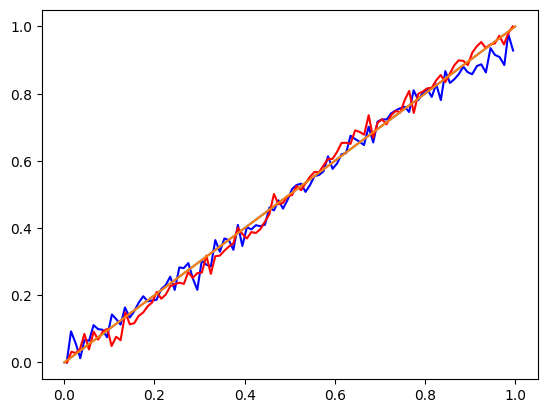

In [74]:
dataframe = pd.read_csv('../data/matches.csv')[7389:51327]
validation = pd.read_csv('../data/matches.csv')[51327:]
validation_2017 = pd.read_csv('../data/matches.csv')[51327:59482]
validation_2018 = pd.read_csv('../data/matches.csv')[59482:68158]
validation_2019 = pd.read_csv('../data/matches.csv')[68158:76425]


data_model, features_dict, labels = get_model(dataframe, hidden_layer, learning_rate, dropout)
_, val_features_dict, val_labels = get_model(validation, hidden_layer, learning_rate, dropout)
_, val_features_dict_2017, val_labels_2017 = get_model(validation_2017, hidden_layer, learning_rate, dropout)
_, val_features_dict_2018, val_labels_2018 = get_model(validation_2018, hidden_layer, learning_rate, dropout)
_, val_features_dict_2019, val_labels_2019 = get_model(validation_2019, hidden_layer, learning_rate, dropout)

reloaded = tf.keras.models.load_model('hidden1300lr0.0005dropout0.8trial4')
print('validation_overall')
results = reloaded.evaluate(val_features_dict, val_labels)
print('validation_2017')
results = reloaded.evaluate(val_features_dict_2017, val_labels_2017)
print('validation_2018')
results = reloaded.evaluate(val_features_dict_2018, val_labels_2018)
print('validation_2019')
results = reloaded.evaluate(val_features_dict_2019, val_labels_2019)
print('training')
results = reloaded.evaluate(features_dict, labels)

val_predictions = reloaded.predict(val_features_dict)
val_labels_list = val_labels.tolist()

predictions = reloaded.predict(features_dict)
labels_list = labels.tolist()

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

x, y = calibration_curve(val_labels_list, val_predictions, n_bins = 100)
plt.plot(y, x, 'b')
plt.plot([0, 1], [0, 1])

x, y = calibration_curve(labels_list, predictions, n_bins = 100)
plt.plot(y, x, 'r')
plt.plot([0, 1], [0, 1])

